- weighting?

In [1]:
import glob
from tqdm import tqdm

In [2]:
import os
import pandas as pd
from choicemodels import MultinomialLogit, MultinomialLogitResults
from choicemodels.tools import MergedChoiceTable

In [3]:
from matplotlib import pyplot as plt

In [4]:
import seaborn as sns

In [5]:
import numpy as np

In [28]:
import pandana as pdna

## Load CHTS data 

In [6]:
data_dir = '/home/mgardner/chts-2012/data'
chts_persons = pd.read_csv(os.path.join(data_dir, 'Deliv_PER.csv'), low_memory=False)
chts_persons_lookup = pd.read_csv(os.path.join(data_dir, 'LookUp_PER.csv'))
chts_households = pd.read_csv(os.path.join(data_dir, 'Deliv_HH.csv'))
chts_households_lookup = pd.read_csv(os.path.join(data_dir, 'LookUp_Home.csv'))

/home/mgardner/anaconda3/envs/proba/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (25,27,31) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## Get Bay Area Households

In [7]:
sfbay_counties = [1, 13, 41, 55, 75, 81, 85, 95, 97]

In [8]:
chts_persons = pd.merge(
    chts_persons.set_index(['SAMPN','PERNO']),
    chts_persons_lookup.set_index(['SAMPN','PERNO']),
    left_index=True, right_index=True,
    suffixes=('_persons', '_lookup')).reset_index()

chts_persons = pd.merge(
    chts_persons.set_index(['SAMPN']),
    chts_households_lookup.set_index(['SAMPN']),
    left_index=True, right_index=True).reset_index()

chts_persons = chts_persons[chts_persons['HCTFIP'].isin(sfbay_counties)].reset_index()

In [9]:
chts_persons.shape

(24030, 188)

## Get Discretionary Activity Coordinates

In [10]:
acts = pd.read_csv(os.path.join(data_dir, 'Deliv_ACTIVITY.csv'))

In [11]:
acts = pd.merge(chts_persons, acts, on=['SAMPN','PERNO'], suffixes=('_persons', '_acts'))

- 1= PERSONAL ACTIVITIES (SLEEPING, PERSONAL CARE, LEISURE, CHORES)
- 4=EXERCISE (WITH OR WITHOUT EQUIPMENT)/PLAYING SPORTS
- 7=USING COMPUTER/TELEPHONE/CELL OR SMART PHONE OR OTHER COMMUNICATIONS DEVICE FOR PERSONAL ACTIVITIES
- 13=NON-WORK RELATED ACTIVITIES (SOCIAL CLUBS, ETC)
- 14=EXERCISE/SPORTS
- 15=VOLUNTEER WORK/ACTIVITIES
- 23=DRIVE THROUGH MEALS (SNACKS, COFFEE, ETC.)
- 24=DRIVE THROUGH OTHER (ATM, BANK)
- 26=SERVICE PRIVATE VEHICLE (GAS, OIL, LUBE, REPAIRS)
- 27=ROUTINE SHOPPING (GROCERIES, CLOTHING, CONVENIENCE STORE, HH MAINTENANCE)
- 28=SHOPPING FOR MAJOR PURCHASES OR SPECIALTY ITEMS (APPLIANCE, ELECTRONICS, NEW VEHICLE, MAJORHH REPAIRS)
- 29=HOUSEHOLD ERRANDS (BANK, DRY CLEANING, ETC.)
- 30=PERSONAL BUSINESS (VISIT GOVERNMENT OFFICE, ATTORNEY, ACCOUNTANT)
- 31=EAT MEAL AT RESTAURANT/DINER
- 32=HEALTH CARE (DOCTOR, DENTIST, EYE CARE, CHIROPRACTOR, VETERINARIAN)
- 33=CIVIC/RELIGIOUS ACTIVITIES
- 34=OUTDOOR EXERCISE (PLAYING SPORTS/JOGGING, BICYCLING, WALKING, WALKING THE DOG, ETC.)
- 35=INDOOR EXERCISE (GYM, YOGA, ETC.)
- 36=ENTERTAINMENT (MOVIES, WATCH SPORTS, ETC)
- 37=SOCIAL/VISIT FRIENDS/RELATIVES

In [12]:
acts_disc = acts[acts['APURP'].isin([1, 4, 7, 13, 14, 15, 23, 24, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37])]

In [13]:
places = pd.read_csv(os.path.join(data_dir, 'Deliv_PLACE.csv'), low_memory=False)
places = places[places['STATE'] == 'CA']

In [14]:
places_lookup = pd.read_csv(os.path.join(data_dir, 'LookUp_PLACE.csv'), low_memory=False)

In [15]:
acts_places = pd.merge(
    acts_disc, places[[col for col in places if col not in ['PNAME',
 'CITY',
 'ZIP',
 'XCORD',
 'YCORD',
 'CTFIP',
 'TRACT',
 'BLOCK',
 'PPrimaryCity']]], on=['SAMPN', 'PERNO', 'PLANO'], suffixes=('_acts_disc', '_places'))

In [16]:
acts_places.shape

(88568, 249)

In [17]:
acts_places = pd.merge(acts_places, places_lookup, on=['SAMPN','PERNO', 'PLANO'], suffixes=('_acts_disc_places', '_lookup'))

In [18]:
acts_places = acts_places[acts_places['CTFIP'].isin(sfbay_counties)]

In [19]:
acts_places.shape

(86607, 258)

In [20]:
acts_places = acts_places[acts_places['PNAME'] != 'HOME']

In [21]:
acts_places.shape

(32810, 258)

In [22]:
obs_df = pd.merge(
    acts_places[['SAMPN', 'AGE', 'EMPLY', 'HBLOCK', 'BLOCK']],
    chts_households[['SAMPN', 'INCOM', 'HHVEH', 'HHSIZ', 'HHLIC']], on='SAMPN')

In [23]:
obs_df.shape

(32810, 9)

In [24]:
obs_df['HBLOCK'] = obs_df['HBLOCK'].astype(str).str.zfill(15)
obs_df['BLOCK'] = obs_df['BLOCK'].astype(str).str.zfill(15)

## Get BEAM Block Group-level Skims

In [21]:
all_files = glob.glob("/home/mgardner/PILATES/pilates/beam/beam_output/result*")

In [54]:
chts_skims = pd.DataFrame()
for file in tqdm(all_files):
    skims = pd.read_csv(
        file, usecols=['timePeriod', 'pathType', 'origin', 'destination','DIST_meters'], low_memory=False)
    skims = skims[(skims['timePeriod'] == 'AM') & (skims['pathType'] == 'SOV')]
    chts_skims = pd.concat((chts_skims, skims), ignore_index=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [05:51<00:00, 13.53s/it]


In [55]:
chts_skims.to_csv('../data/chts_skims.csv', index=False)

In [25]:
chts_skims = pd.read_csv('../data/chts_skims.csv')

## Create Alts from UrbanSim Block Data

In [26]:
store = pd.HDFStore('/home/mgardner/PILATES/pilates/urbansim/data/custom_mpo_06197001_model_data.h5')
blocks = store['blocks']
nodes = store['nodes']
edges = store['edges']
units = store['residential_units']
hh = store['households']
jobs = store['jobs']
p = store['persons']

In [27]:
units_per_block = units.reset_index().groupby('block_id')[['unit_id']].count()
units_per_block.rename(columns={'unit_id': 'res_units'}, inplace=True)

In [29]:
nodes.set_index('id', inplace=True)

In [31]:
net=pdna.Network(nodes["x"], nodes["y"], edges["from"], edges["to"],
                 edges[["weight"]])

Generating contraction hierarchies with 36 threads.
Setting CH node vector of size 92395
Setting CH edge vector of size 232266
Range graph removed 233224 edges of 464532
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


In [32]:
net.precompute(3000)

In [33]:
blocks['node_id'] = net.get_node_ids(blocks.x, blocks.y)

In [34]:
embc_bg_id = '060750105002'
sj_bg_id = '060133551141'
embc_node_id = blocks.loc['060750105002001', 'node_id']
sj_node_id = blocks.loc['060133551141003', 'node_id']

In [35]:
obs_df['node_id_home'] = blocks['node_id'].reindex(obs_df['HBLOCK']).values

In [37]:
pp_block = hh.groupby('block_id')['persons'].sum()

In [39]:
blocks.shape

(108469, 14)

In [40]:
retail_jobs = jobs[jobs['sector_id'] == '44-45'].groupby('block_id').count()
total_jobs = jobs.groupby('block_id').count()
total_jobs.rename(columns={'sector_id': 'total_jobs'}, inplace=True)
retail_jobs.rename(columns={'sector_id': 'retail_jobs'}, inplace=True)
jobs = pd.merge(total_jobs, retail_jobs, left_index=True, right_index=True, how='outer').fillna(0)
jobs['pct_retail'] = jobs['retail_jobs'] / jobs['total_jobs']

In [41]:
blocks = pd.merge(blocks, jobs[['pct_retail','total_jobs']], left_index=True, right_index=True, how='left').fillna(0)
blocks = pd.merge(blocks, pp_block, left_index=True, right_index=True, how='left').fillna(0)
blocks = pd.merge(blocks, units_per_block, left_index=True, right_index=True, how='left').fillna(0)
blocks['pop_density'] = blocks['persons'] / blocks['square_meters_land']
blocks['jobs_per_res_unit'] = blocks['total_jobs'] / blocks['res_units']
blocks = blocks[blocks['square_meters_land'] > 0]

In [42]:
blocks.columns

Index(['x', 'y', 'square_meters_land', 'county_id', 'cousub', 'tract_id',
       'block_group_id', 'MPO_ID', 'state_id', 'residential_unit_capacity',
       'employment_capacity', 'sum_acres', 'zone_id', 'node_id', 'pct_retail',
       'total_jobs', 'persons', 'res_units', 'pop_density',
       'jobs_per_res_unit'],
      dtype='object')

In [45]:
blocks = blocks[['total_jobs', 'pct_retail', 'persons', 'pop_density', 'res_units', 'jobs_per_res_unit', 'node_id']]

In [46]:
alts_df = blocks

In [47]:
alts_df['dest_block_grp'] = alts_df.index.str[0:12].values

In [48]:
alts_df['dtsj_bg_id'] = sj_bg_id
alts_df['dtsf_bg_id'] = embc_bg_id

In [61]:
alts_df['dtsj_node_id'] = sj_node_id
alts_df['dtsf_node_id'] = embc_node_id

## Filter Choosers w/ Home Locations not in UrbanSim Block Data

In [49]:
obs_df = obs_df[obs_df['BLOCK'].isin(blocks.index)]

In [50]:
obs_df.shape

(32722, 10)

In [51]:
obs_df = obs_df[obs_df['HBLOCK'].isin(blocks.index)]

In [52]:
obs_df.shape

(32690, 10)

In [53]:
obs_df['block_grp'] = obs_df['HBLOCK'].str[0:12]

In [54]:
obs_df['node_id_home'] = obs_df['node_id_home'].astype(int)

## Chooser Feature Extraction

In [56]:
obs_df['inc_lt_75k'] = obs_df['INCOM'] < 6
obs_df['inc_gt_150k'] = obs_df['INCOM'] > 7
obs_df['inc_gt_200k'] = obs_df['INCOM'] > 8

In [57]:
obs_df['age_lt_18'] = obs_df['AGE'] < 18
obs_df['age_gt_65'] = obs_df['AGE'] > 65

In [58]:
obs_df['hhveh_gt_1'] = obs_df['HHVEH'] > 1
obs_df['hhveh_is_1'] = obs_df['HHVEH'] == 1
obs_df['hhveh_is_0'] = obs_df['HHVEH'] == 0
obs_df['hhveh_gt_0'] = obs_df['HHVEH'] > 0
obs_df['veh_pp'] = obs_df['HHVEH'] / obs_df['HHSIZ']
obs_df['veh_pp_gt_1'] = obs_df['veh_pp'] > 1
obs_df['veh_per_driver'] = obs_df['HHVEH'] / obs_df['HHLIC']
obs_df['veh_per_driver_gt_1'] = obs_df['veh_per_driver'] > 1

## Format Skims as Interaction Terms

In [55]:
chts_skims.rename(columns={'origin': 'block_grp', 'destination':'dest_block_grp'}, inplace=True)
chts_skims['block_grp'] = chts_skims['block_grp'].astype(str).str.zfill(12)
chts_skims['dest_block_grp'] = chts_skims['dest_block_grp'].astype(str).str.zfill(12)

#### Filter choosers/alts without origin/dest in skims

In [59]:
obs_df = obs_df[obs_df['block_grp'].isin(chts_skims['block_grp'])]
obs_df = obs_df[obs_df['BLOCK'].isin(alts_df.index)]
alts_df = alts_df[alts_df['dest_block_grp'].isin(chts_skims['dest_block_grp'])]

#### landmark dists

In [60]:
chts_skims.set_index(['block_grp', 'dest_block_grp'], inplace=True)

In [62]:
alts_df = pd.merge(alts_df, chts_skims[['DIST_meters']], left_on=['dest_block_grp', 'dtsj_bg_id'], right_index=True, how='left')
alts_df.rename(columns={'DIST_meters': 'DIST_DTSJ'}, inplace=True)
alts_df = pd.merge(alts_df, chts_skims[['DIST_meters']], left_on=['dest_block_grp', 'dtsf_bg_id'], right_index=True, how='left')
alts_df.rename(columns={'DIST_meters': 'DIST_DTSF'}, inplace=True)
alts_df['dist_to_nearest_cbd'] = alts_df[['DIST_DTSF', 'DIST_DTSJ']].min(axis=1)

In [63]:
alts_df['pdna_dtsj_dist'] = net.shortest_path_lengths(alts_df['node_id'], alts_df['dtsj_node_id'])
alts_df['pdna_dtsf_dist'] = net.shortest_path_lengths(alts_df['node_id'], alts_df['dtsf_node_id'])

In [64]:
alts_df['pdna_dist_to_nearest_cbd'] = alts_df[['pdna_dtsj_dist', 'pdna_dtsf_dist']].min(axis=1)
alts_df['dist_to_nearest_cbd'] = alts_df['dist_to_nearest_cbd'].replace(np.inf, np.nan)
alts_df['pdna_dist_to_nearest_cbd'] = alts_df['pdna_dist_to_nearest_cbd'].replace(np.inf, np.nan)
alts_df.loc[pd.isnull(alts_df['dist_to_nearest_cbd']), 'dist_to_nearest_cbd'] = alts_df.loc[pd.isnull(alts_df['dist_to_nearest_cbd']), 'pdna_dist_to_nearest_cbd']

In [65]:
alts_df['dist_to_nearest_cbd'].describe()

count    106910.000000
mean      50833.283030
std       30264.517755
min          29.707000
25%       25994.571000
50%       46564.770000
75%       71994.314000
max      167612.453000
Name: dist_to_nearest_cbd, dtype: float64

## Create Merged Choice Table

In [66]:
obs_df = obs_df[(obs_df['AGE'] < 98) & (obs_df['INCOM'] < 98) & (obs_df['HHSIZ'] < 98)]

In [67]:
sample_size = 1000

In [68]:
%%time 
mct = MergedChoiceTable(
    obs_df, alts_df, chosen_alternatives='BLOCK', sample_size=sample_size, interaction_terms=chts_skims[['DIST_meters']])

CPU times: user 32.2 s, sys: 7.93 s, total: 40.2 s
Wall time: 40.1 s


In [69]:
mct_df = mct.to_frame().reset_index()

#### pandana dists

In [70]:
%%time
dists = net.shortest_path_lengths(mct_df['node_id_home'], mct_df['node_id'])

CPU times: user 18min 39s, sys: 1.29 s, total: 18min 40s
Wall time: 39.2 s


In [71]:
mct_df['pdna_dists'] = dists

Text(0.5, 1.0, 'Distance (m)')

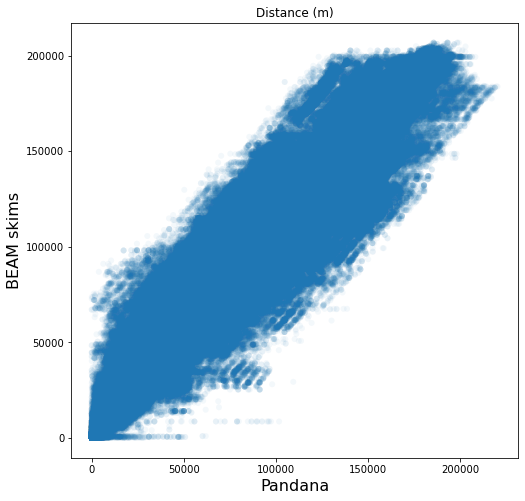

In [118]:
fig, ax = plt.subplots(figsize=(8,8))
sns.scatterplot(data=mct_df.loc[mct_df['pdna_dists'] < 1e6],
                x='pdna_dists', y='DIST_meters', alpha=0.05,
                edgecolor='none')
ax.set_xlabel("Pandana", fontsize=16)
ax.set_ylabel("BEAM skims", fontsize=16)
ax.set_title("Distance (m)")

#### Replace Null BEAM dists with pdna dists

In [72]:
mct_df.loc[mct_df['pdna_dists'] > 1e6, 'pdna_dists'] = np.nan
mct_df.loc[pd.isnull(mct_df['DIST_meters']), 'DIST_meters'] = mct_df.loc[pd.isnull(mct_df['DIST_meters']), 'pdna_dists']

In [73]:
mct_df.loc[pd.isnull(mct_df['pdna_dists']), 'pdna_dists'] = mct_df.loc[pd.isnull(mct_df['pdna_dists']), 'DIST_meters']

In [74]:
mct_df.loc[mct_df['pdna_dists'] == 0, 'pdna_dists'] = mct_df.loc[mct_df['pdna_dists'] == 0, 'DIST_meters']

#### Impute missing dists (for skim dists only)

In [75]:
counts = mct_df.groupby('obs_id')[['DIST_meters']].count()
mean_dists = mct_df.groupby('obs_id')[['DIST_meters']].mean()

In [76]:
mean_dists.rename(columns={'DIST_meters': 'mean_DIST_meters'}, inplace=True)

In [77]:
print("Imputing {0} values at most for each chooser".format(sample_size - counts.min().values[0]))

Imputing 5 values at most for each chooser


In [78]:
mct_df = pd.merge(mct_df, mean_dists, left_on='obs_id', right_index=True)
mct_df.loc[pd.isnull(mct_df['DIST_meters']), 'DIST_meters'] = mct_df.loc[pd.isnull(mct_df['DIST_meters']), 'mean_DIST_meters']

In [79]:
mct_df['res_unit_gt_0'] = mct_df['res_units'] > 0

In [80]:
mct_df['jobs_per_res_unit'].replace(np.inf, np.nan, inplace=True)
mct_df['jobs_per_res_unit'] = mct_df['jobs_per_res_unit'].fillna(0)

In [81]:
mct_df = mct_df.sort_values(['obs_id', 'chosen'], ascending=False)
mct_df = mct_df[[
    'obs_id', 'block_id', 'age_lt_18', 'age_gt_65',
    'inc_lt_75k', 'inc_gt_150k', 'veh_pp','veh_per_driver', 'veh_pp_gt_1', 'veh_per_driver_gt_1',
    'hhveh_gt_1', 'hhveh_gt_0', 'hhveh_is_0', 'hhveh_is_1', 'pct_retail', 'total_jobs', 'res_unit_gt_0',
    'jobs_per_res_unit', 'persons', 'pop_density','DIST_meters', 'dist_to_nearest_cbd',
    'chosen']].set_index(['obs_id', 'block_id'])

In [82]:
mct_df[['pct_retail', 'total_jobs', 'jobs_per_res_unit', 'persons', 'pop_density', 'dist_to_nearest_cbd']].describe()

,pct_retail,total_jobs,jobs_per_res_unit,persons,pop_density,dist_to_nearest_cbd
count,2.880000e+07,2.880000e+07,2.880000e+07,2.880000e+07,2.880000e+07,2.880000e+07
mean,3.999457e-02,4.043771e+01,2.226269e+00,6.371853e+01,2.632922e-03,5.083412e+04
std,1.552238e-01,3.359169e+02,5.553243e+01,1.157038e+02,6.536241e-03,3.027081e+04
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.970700e+01
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.599457e+04
50%,0.000000e+00,1.000000e+00,0.000000e+00,2.600000e+01,1.282181e-03,4.657564e+04
75%,0.000000e+00,9.000000e+00,1.250000e-01,8.300000e+01,3.685864e-03,7.201334e+04
max,1.000000e+00,4.231800e+04,1.410600e+04,3.131000e+03,1.215625e+00,1.676125e+05


In [83]:
mct = MergedChoiceTable.from_df(mct_df)

In [238]:
%%time
results = MultinomialLogit(
    mct,
    model_expression='np.log1p(retail_jobs) + np.log1p(pop_density) + (np.log(DIST_from_home) / (veh_pp_gt_1 + inc_lt_75k + inc_gt_150k + age_lt_18 + age_gt_65)) - 1')
results.fit()

CPU times: user 3min 58s, sys: 4min 56s, total: 8min 55s
Wall time: 57 s


                  CHOICEMODELS ESTIMATION RESULTS                   
Dep. Var.:                chosen   No. Observations:          28,783
Model:         Multinomial Logit   Df Residuals:              28,775
Method:       Maximum Likelihood   Df Model:                       8
Date:                 2021-12-24   Pseudo R-squ.:              0.438
Time:                      00:03   Pseudo R-bar-squ.:          0.437
AIC:                 223,688.832   Log-Likelihood:      -111,836.416
BIC:                 223,754.972   LL-Null:             -198,825.920
                                                 coef   std err            z     P>|z|   Conf. Int.
---------------------------------------------------------------------------------------------------
np.log1p(retail_jobs)                          0.7061     0.003      238.257     0.000             
np.log1p(pop_density)                        -33.4516     0.871      -38.393     0.000             
np.log(DIST_from_home)                        -1

In [176]:
%%time
expression = 'np.log1p(retail_jobs) + np.log1p(pop_density) + (np.log1p(DIST_meters)' + \
    '/ (hhveh_gt_1 + veh_pp + inc_lt_75k + inc_gt_150k + age_lt_18 + age_gt_65)) - 1'
results = MultinomialLogit(
    mct,
    model_expression=expression)
results.fit()

CPU times: user 3min 22s, sys: 4min 2s, total: 7min 25s
Wall time: 50.8 s


                  CHOICEMODELS ESTIMATION RESULTS                   
Dep. Var.:                chosen   No. Observations:          28,800
Model:         Multinomial Logit   Df Residuals:              28,792
Method:       Maximum Likelihood   Df Model:                       8
Date:                 2021-12-29   Pseudo R-squ.:              0.440
Time:                      11:08   Pseudo R-bar-squ.:          0.440
AIC:                 222,780.129   Log-Likelihood:      -111,382.064
BIC:                 222,846.274   LL-Null:             -198,943.352
                                               coef   std err          z     P>|z|   Conf. Int.
-----------------------------------------------------------------------------------------------
np.log1p(retail_jobs)                        0.7153     0.003    241.798     0.000             
np.log1p(DIST_meters)                       -1.5609     0.002   -725.950     0.000             
np.log1p(DIST_meters):hhveh_gt_1[T.True]    -0.0058     0.002   

In [180]:
%%time
expression = 'np.log1p(retail_jobs) + np.log1p(pop_density):(age_lt_18 + age_gt_65) + (np.log1p(DIST_meters)' + \
    '/ (hhveh_gt_1 + veh_pp + inc_lt_75k + inc_gt_150k)) - 1'
results = MultinomialLogit(
    mct,
    model_expression=expression)
results.fit()

CPU times: user 14min 38s, sys: 11min 33s, total: 26min 11s
Wall time: 2min 12s


                  CHOICEMODELS ESTIMATION RESULTS                   
Dep. Var.:                chosen   No. Observations:          28,800
Model:         Multinomial Logit   Df Residuals:              28,791
Method:       Maximum Likelihood   Df Model:                       9
Date:                 2021-12-29   Pseudo R-squ.:              0.441
Time:                      11:47   Pseudo R-bar-squ.:          0.441
AIC:                 222,300.495   Log-Likelihood:      -111,141.248
BIC:                 222,374.908   LL-Null:             -198,943.352
                                                coef   std err          z     P>|z|   Conf. Int.
------------------------------------------------------------------------------------------------
np.log1p(retail_jobs)                         0.7068     0.003    238.348     0.000             
np.log1p(pop_density):age_lt_18[False]      -28.0400     0.907    -30.900     0.000             
np.log1p(pop_density):age_lt_18[True]       -58.9143     3.7

In [179]:
%%time
expression = 'np.log1p(retail_jobs) + np.log1p(pop_density):age_lt_18 + (np.log1p(DIST_meters)' + \
    '/ (hhveh_gt_1 + veh_pp + inc_lt_75k + inc_gt_150k + age_gt_65)) - 1'
results = MultinomialLogit(
    mct,
    model_expression=expression)
results.fit()

CPU times: user 10min 32s, sys: 8min 20s, total: 18min 52s
Wall time: 1min 40s


                  CHOICEMODELS ESTIMATION RESULTS                   
Dep. Var.:                chosen   No. Observations:          28,800
Model:         Multinomial Logit   Df Residuals:              28,791
Method:       Maximum Likelihood   Df Model:                       9
Date:                 2021-12-29   Pseudo R-squ.:              0.441
Time:                      11:42   Pseudo R-bar-squ.:          0.441
AIC:                 222,320.350   Log-Likelihood:      -111,151.175
BIC:                 222,394.764   LL-Null:             -198,943.352
                                                coef   std err          z     P>|z|   Conf. Int.
------------------------------------------------------------------------------------------------
np.log1p(retail_jobs)                         0.7070     0.003    238.439     0.000             
np.log1p(pop_density):age_lt_18[False]      -32.4729     0.892    -36.415     0.000             
np.log1p(pop_density):age_lt_18[True]       -58.6271     3.7

In [261]:
%%time
expression = 'np.log1p(pct_retail) + np.log1p(total_jobs) + np.log1p(pop_density):(age_lt_18 + age_gt_65) + (np.log1p(DIST_meters)' + \
    '/ (hhveh_gt_1 + veh_pp + inc_lt_75k + inc_gt_150k)) - 1'
results = MultinomialLogit(
    mct,
    model_expression=expression)
results.fit()

CPU times: user 19min 45s, sys: 14min 28s, total: 34min 14s
Wall time: 2min 46s


                  CHOICEMODELS ESTIMATION RESULTS                   
Dep. Var.:                chosen   No. Observations:          28,800
Model:         Multinomial Logit   Df Residuals:              28,790
Method:       Maximum Likelihood   Df Model:                      10
Date:                 2021-12-29   Pseudo R-squ.:              0.473
Time:                      13:25   Pseudo R-bar-squ.:          0.473
AIC:                 209,618.704   Log-Likelihood:      -104,799.352
BIC:                 209,701.385   LL-Null:             -198,943.352
                                                coef   std err          z     P>|z|   Conf. Int.
------------------------------------------------------------------------------------------------
np.log1p(pct_retail)                          2.2201     0.034     65.646     0.000             
np.log1p(total_jobs)                          0.6145     0.003    212.570     0.000             
np.log1p(pop_density):age_lt_18[False]      -25.3214     0.9

In [123]:
%%time
expression = 'np.log1p(pct_retail) + np.log1p(total_jobs) + (np.log1p(pop_density))/(age_lt_18 + age_gt_65) + (np.log1p(DIST_meters)' + \
    '/ (hhveh_gt_1 + veh_pp + inc_lt_75k + inc_gt_150k)) - 1'
results = MultinomialLogit(
    mct,
    model_expression=expression)
results.fit()

CPU times: user 18min 3s, sys: 13min 16s, total: 31min 19s
Wall time: 2min 32s


                  CHOICEMODELS ESTIMATION RESULTS                   
Dep. Var.:                chosen   No. Observations:          28,800
Model:         Multinomial Logit   Df Residuals:              28,790
Method:       Maximum Likelihood   Df Model:                      10
Date:                 2021-12-29   Pseudo R-squ.:              0.473
Time:                      22:55   Pseudo R-bar-squ.:          0.473
AIC:                 209,641.914   Log-Likelihood:      -104,810.957
BIC:                 209,724.596   LL-Null:             -198,943.352
                                                coef   std err          z     P>|z|   Conf. Int.
------------------------------------------------------------------------------------------------
np.log1p(pct_retail)                          2.2377     0.034     66.182     0.000             
np.log1p(total_jobs)                          0.6148     0.003    212.912     0.000             
np.log1p(pop_density)                       -25.1217     0.9

In [386]:
%%time
expression = 'np.log1p(pct_retail) + np.log1p(total_jobs) + np.log1p(jobs_per_res_unit)/np.log1p(pop_density) + (np.log1p(DIST_meters)' + \
    ':veh_pp) - 1'
results = MultinomialLogit(
    mct,
    model_expression=expression)
results.fit()

CPU times: user 4min 22s, sys: 4min 42s, total: 9min 4s
Wall time: 55.1 s


                  CHOICEMODELS ESTIMATION RESULTS                   
Dep. Var.:                chosen   No. Observations:          28,800
Model:         Multinomial Logit   Df Residuals:              28,795
Method:       Maximum Likelihood   Df Model:                       5
Date:                 2021-12-29   Pseudo R-squ.:              0.398
Time:                      16:19   Pseudo R-bar-squ.:          0.398
AIC:                 239,712.730   Log-Likelihood:      -119,851.365
BIC:                 239,754.071   LL-Null:             -198,943.352
                                                        coef   std err            z     P>|z|   Conf. Int.
----------------------------------------------------------------------------------------------------------
np.log1p(pct_retail)                                  2.2993     0.033       69.469     0.000             
np.log1p(total_jobs)                                  0.6245     0.003      244.424     0.000             
np.log1p(jobs_per_re

In [465]:
%%time
expression = 'np.log1p(pct_retail) + np.log1p(total_jobs) + ' + \
    'np.log1p(jobs_per_res_unit)/np.log1p(pop_density) + (DIST_meters:veh_pp) - 1'
results = MultinomialLogit(
    mct,
    model_expression=expression)
results.fit()

CPU times: user 15min 23s, sys: 16min 50s, total: 32min 13s
Wall time: 2min 56s


                  CHOICEMODELS ESTIMATION RESULTS                   
Dep. Var.:                chosen   No. Observations:          28,800
Model:         Multinomial Logit   Df Residuals:              28,795
Method:       Maximum Likelihood   Df Model:                       5
Date:                 2021-12-29   Pseudo R-squ.:              0.412
Time:                      17:29   Pseudo R-bar-squ.:          0.412
AIC:                 233,916.498   Log-Likelihood:      -116,953.249
BIC:                 233,957.838   LL-Null:             -198,943.352
                                                        coef   std err          z     P>|z|   Conf. Int.
--------------------------------------------------------------------------------------------------------
np.log1p(pct_retail)                                  2.1366     0.033     63.950     0.000             
np.log1p(total_jobs)                                  0.5701     0.002    259.237     0.000             
np.log1p(jobs_per_res_unit) 

In [157]:
%%time
expression = 'np.log1p(pct_retail) + np.log1p(total_jobs) + ' + \
    'np.log1p(pop_density) + veh_pp:np.log1p(jobs_per_res_unit) + np.log1p(dist_to_nearest_cbd) - 1'
results = MultinomialLogit(
    mct,
    model_expression=expression)
fitted = results.fit()
print(fitted.report_fit())

                  CHOICEMODELS ESTIMATION RESULTS                   
Dep. Var.:                chosen   No. Observations:          28,800
Model:         Multinomial Logit   Df Residuals:              28,795
Method:       Maximum Likelihood   Df Model:                       5
Date:                 2021-12-29   Pseudo R-squ.:              0.158
Time:                      23:18   Pseudo R-bar-squ.:          0.158
AIC:                 335,176.888   Log-Likelihood:      -167,583.444
BIC:                 335,218.229   LL-Null:             -198,943.352
                                        coef   std err         z     P>|z|   Conf. Int.
---------------------------------------------------------------------------------------
np.log1p(pct_retail)                  2.3095     0.031    73.666     0.000             
np.log1p(total_jobs)                  0.5798     0.003   201.861     0.000             
np.log1p(pop_density)                -8.3015     0.850    -9.769     0.000             
veh_pp:n

In [164]:
mct_df['intx'] = mct_df['veh_pp'] * np.log1p(mct_df['jobs_per_res_unit'])

In [165]:
mct = MergedChoiceTable.from_df(mct_df)

In [166]:
%%time
expression = 'np.log1p(pct_retail) + np.log1p(total_jobs) + ' + \
    'np.log1p(pop_density) + intx + np.log1p(dist_to_nearest_cbd) - 1'
results = MultinomialLogit(
    mct,
    model_expression=expression)
results.fit()

CPU times: user 4min 25s, sys: 4min 46s, total: 9min 12s
Wall time: 55.2 s


                  CHOICEMODELS ESTIMATION RESULTS                   
Dep. Var.:                chosen   No. Observations:          28,800
Model:         Multinomial Logit   Df Residuals:              28,795
Method:       Maximum Likelihood   Df Model:                       5
Date:                 2021-12-30   Pseudo R-squ.:              0.158
Time:                      10:29   Pseudo R-bar-squ.:          0.158
AIC:                 335,176.888   Log-Likelihood:      -167,583.444
BIC:                 335,218.229   LL-Null:             -198,943.352
                                   coef   std err         z     P>|z|   Conf. Int.
----------------------------------------------------------------------------------
np.log1p(pct_retail)             2.3095     0.031    73.666     0.000             
np.log1p(total_jobs)             0.5798     0.003   201.861     0.000             
np.log1p(pop_density)           -8.3015     0.850    -9.769     0.000             
intx                             

In [85]:
%%time
expression = 'np.log1p(pct_retail) + np.log1p(total_jobs) + ' + \
    'np.log1p(persons) + np.log1p(jobs_per_res_unit) + np.log1p(dist_to_nearest_cbd):veh_pp - 1'
results = MultinomialLogit(
    mct,
    model_expression=expression)
fitted = results.fit()
print(fitted.report_fit())

                  CHOICEMODELS ESTIMATION RESULTS                   
Dep. Var.:                chosen   No. Observations:          28,800
Model:         Multinomial Logit   Df Residuals:              28,795
Method:       Maximum Likelihood   Df Model:                       5
Date:                 2021-12-30   Pseudo R-squ.:              0.159
Time:                      10:52   Pseudo R-bar-squ.:          0.159
AIC:                 334,633.324   Log-Likelihood:      -167,311.662
BIC:                 334,674.665   LL-Null:             -198,943.352
                                          coef   std err         z     P>|z|   Conf. Int.
-----------------------------------------------------------------------------------------
np.log1p(pct_retail)                    2.3193     0.031    73.770     0.000             
np.log1p(total_jobs)                    0.6008     0.002   242.290     0.000             
np.log1p(persons)                       0.0508     0.002    22.641     0.000            

# Simulate

In [86]:
fitted.fitted_parameters

[2.3192508668719496,
 0.6008136334725452,
 0.050763380696939274,
 -0.01931958436727215,
 0.12227377089378402]

In [88]:
p = pd.merge(p, hh, left_on='household_id', right_index=True)

In [390]:
alts_df.shape

(106910, 7)

In [97]:
num_choosers = int(np.floor((750/200) * len(alts_df)))
print(num_choosers)

400912


In [123]:
num_choosers = 400000

In [130]:
choosers = p[['cars']].sample(num_choosers).values

In [100]:
import jax
import jaxlib
from jax import grad, jit, vmap
import jax.numpy as np
import jax.random as random

In [120]:
from jax import devices, device_put

In [91]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

gpu


In [92]:
os.chdir('../scripts')

In [93]:
import compute_pmass as pm
import compute_iter_metrics as cim
import large_mnl as lmnl

In [94]:
fitted.model_expression

'np.log1p(pct_retail) + np.log1p(total_jobs) + np.log1p(persons) + np.log1p(jobs_per_res_unit) + np.log1p(dist_to_nearest_cbd):veh_pp - 1'

In [95]:
alts = alts_df[['pct_retail','total_jobs','persons', 'jobs_per_res_unit', 'dist_to_nearest_cbd']].values

In [96]:
alts = np.log1p(alts)

In [124]:
sample_rates = [.1, .2, .3, .4, .5, .6, .7, .8, .9, 1.0]
coeffs = np.array(fitted.fitted_parameters)
key = random.PRNGKey(0)
num_iters = 10
keys = random.split(key, num_choosers)

In [125]:
key_dim = key.shape[0]

In [133]:
n_chooser_batches = 10000

In [134]:
choosers_per_batch = int(num_choosers / n_chooser_batches)

In [118]:
from functools import partial

In [135]:
choosers = choosers.reshape((n_chooser_batches, choosers_per_batch))
keys = keys.reshape((n_chooser_batches, choosers_per_batch, key_dim))

partial_interaction = partial(
    lmnl.interaction_probs_all,
    alts,
    coeffs,
    1)

In [140]:
# store results on cpu to preserve space on GPU for computation
cpu = devices("cpu")[0]
results = device_put(np.zeros((10, alts.shape[0])), device=cpu)

2021-12-30 11:08:57.328135: W external/org_tensorflow/tensorflow/core/common_runtime/bfc_allocator.cc:456] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.08MiB (rounded to 4276480)requested by op 
2021-12-30 11:08:57.328414: W external/org_tensorflow/tensorflow/core/common_runtime/bfc_allocator.cc:467] ***************************************************************************************************x
2021-12-30 11:08:57.328461: E external/org_tensorflow/tensorflow/compiler/xla/pjrt/pjrt_stream_executor_client.cc:1955] Execution of replica 0 failed: Resource exhausted: Out of memory while trying to allocate 4276400 bytes.


RuntimeError: Resource exhausted: Out of memory while trying to allocate 4276400 bytes.

In [138]:
for i in tqdm(range(n_chooser_batches)):
    chooser_batch = choosers[i]
    key_batch = keys[i]
    probs = vmap(partial_interaction)((chooser_batch, key_batch))
    results = results + probs.sum(axis=0)
    del probs

  0%|                                                                                          | 0/10000 [00:00<?, ?it/s]2021-12-30 11:07:52.036263: W external/org_tensorflow/tensorflow/core/common_runtime/bfc_allocator.cc:456] Allocator (GPU_0_bfc) ran out of memory trying to allocate 212.07MiB (rounded to 222373888)requested by op 
2021-12-30 11:07:52.036532: W external/org_tensorflow/tensorflow/core/common_runtime/bfc_allocator.cc:467] ***************************************************************************************************x
2021-12-30 11:07:52.036582: E external/org_tensorflow/tensorflow/compiler/xla/pjrt/pjrt_stream_executor_client.cc:1955] Execution of replica 0 failed: Resource exhausted: Out of memory while trying to allocate 222373720 bytes.
  0%|                                                                                          | 0/10000 [00:11<?, ?it/s]


RuntimeError: Resource exhausted: Out of memory while trying to allocate 222373720 bytes.

In [104]:
%%time
results = vmap(
    lmnl.interaction_probs_all, in_axes=(None, None, None, 0))(
    alts, coeffs, 1, (choosers, keys))

2021-12-30 10:57:53.861663: W external/org_tensorflow/tensorflow/core/common_runtime/bfc_allocator.cc:456] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.56TiB (rounded to 1714460076800)requested by op 
2021-12-30 10:57:53.861894: W external/org_tensorflow/tensorflow/core/common_runtime/bfc_allocator.cc:467] *___________________________________________________________________________________________________
2021-12-30 10:57:53.861941: E external/org_tensorflow/tensorflow/compiler/xla/pjrt/pjrt_stream_executor_client.cc:1955] Execution of replica 0 failed: Resource exhausted: Out of memory while trying to allocate 1714460076800 bytes.


RuntimeError: Resource exhausted: Out of memory while trying to allocate 1714460076800 bytes.